### Notebook for various analysis using RisingBALLER learned embeddings

In [20]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#### 1. Read the data

In [ ]:
import pandas as pd

df_input = pd.read_csv('../dataset/statsbomb/df_raw_counts_players_matches.csv') # consider replacing by the right path in your folder
df_input

In [ ]:
LABEL2PLAYER_NAME = dict(enumerate(df_input['player_name'].astype('category').cat.categories))
PLAYER_NAME2LABEL = {v: k for k, v in LABEL2PLAYER_NAME.items()}

LABEL2TEAM_NAME = dict(enumerate(df_input['team_name'].astype('category').cat.categories))
TEAM_NAME2LABEL = {v: k for k, v in LABEL2TEAM_NAME.items()}

print(len(PLAYER_NAME2LABEL))
print(len(TEAM_NAME2LABEL))

5106
141


#### 2. Embeddings analysis

In [3]:
players_embeddings = np.load('pretrained_ckpt/players_embeddings_1l128d2h_wo_teams_emb_statsbomb_2454games.npy')
positions_embeddings = np.load('pretrained_ckpt/positions_embeddings_1l128d2h_wo_teams_emb_statsbomb_2454games.npy')

players_embeddings.shape, positions_embeddings.shape

((5106, 128), (25, 128))

##### 2.1 Positions clustering using the learned positions embeddings

The idea is to see if the model captures pitch zones in the positions embeddings

In [7]:
positions_list = ['GK', 'RB', 'RCB', 'CB', 'LCB', 'LB', 'RWB', 'RDM', 'CDM', 'LDM', 'LWB',
                      'RM', 'RCM', 'CM', 'LCM', 'LM', 'RW', 'RAM', 'CAM', 'LAM', 'LW',
                      'RCF', 'ST', 'LCF', 'SS']

def cluster_positions_cosine(k):
    X = positions_embeddings

    X_normalized = normalize(X, axis=1)

    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1000)
    kmeans.fit(X_normalized)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    positions_list = ['GK', 'RB', 'RCB', 'CB', 'LCB', 'LB', 'RWB', 'RDM', 'CDM', 'LDM', 'LWB',
                      'RM', 'RCM', 'CM', 'LCM', 'LM', 'RW', 'RAM', 'CAM', 'LAM', 'LW',
                      'RCF', 'ST', 'LCF', 'SS']

    clusters = {}

    for i in range(k):
        mask = np.where(labels == i)[0]  
        cluster_positions = [positions_list[j] for j in mask]

        for pos in cluster_positions:
            clusters[pos] = i  

        distances = 1 - np.dot(X_normalized[mask], centers[i])  # Cosine distance = 1 - cosine similarity

        sorted_indices = np.argsort(distances)
        sorted_cluster = [cluster_positions[idx] for idx in sorted_indices]

        print(f'Cluster {i} (sorted by proximity to center): {sorted_cluster}')

    cluster_colors = {i: plt.cm.tab10(i) for i in range(k)}  

    return clusters, cluster_colors

def draw_pitch():
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_facecolor('#90EE90')  # Light green background
    ax.add_patch(patches.Rectangle((0, 0), 130, 90, color='#90EE90'))  # Light green background

    # Pitch Outline & Centre Line
    plt.plot([0, 0], [0, 90], color="black")  # Left touchline
    plt.plot([0, 130], [90, 90], color="black")  # Top goal line
    plt.plot([130, 130], [90, 0], color="black")  # Right touchline
    plt.plot([130, 0], [0, 0], color="black")  # Bottom goal line
    plt.plot([65, 65], [0, 90], color="black")  # Centre line

    # Left Penalty Area
    plt.plot([18, 18], [65, 25], color="black")
    plt.plot([0, 18], [65, 65], color="black")
    plt.plot([0, 18], [25, 25], color="black")

    # Right Penalty Area
    plt.plot([130, 112], [65, 65], color="black")
    plt.plot([112, 112], [65, 25], color="black")
    plt.plot([130, 112], [25, 25], color="black")

    # Centre Circle
    centre_circle = patches.Circle((65, 45), 9.15, color="black", fill=False)
    centre_spot = patches.Circle((65, 45), 0.8, color="black")
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)

    # Penalty spots
    left_penalty = patches.Circle((12, 45), 0.8, color="black")
    right_penalty = patches.Circle((118, 45), 0.8, color="black")
    ax.add_patch(left_penalty)
    ax.add_patch(right_penalty)

    # Set limits and remove axis
    plt.xlim(0, 130)
    plt.ylim(0, 90)
    plt.axis('off')

    return fig, ax

def plot_positions(positions, clusters, cluster_colors):
    # Draw the football pitch
    fig, ax = draw_pitch()

    # Plot each position with its acronym and corresponding color
    for pos, coord in positions.items():
        cluster_id = clusters.get(pos, None)  # Get the cluster for the position
        color = cluster_colors[cluster_id] if cluster_id is not None else 'black'  # Default to black if not found
        ax.text(coord[0], coord[1], pos, ha='center', va='center', fontsize=12, color=color, fontweight='bold')

    # Show plot
    plt.show()

Cluster 0 (sorted by proximity to center): ['CDM', 'RCB', 'LCB', 'LW', 'RW', 'RB', 'GK', 'ST', 'LWB', 'CAM', 'LB', 'RCF', 'RDM', 'CB', 'RWB', 'RAM']
Cluster 1 (sorted by proximity to center): ['RCM', 'LM', 'LCM', 'RM', 'CM', 'LDM', 'LCF', 'LAM', 'SS']


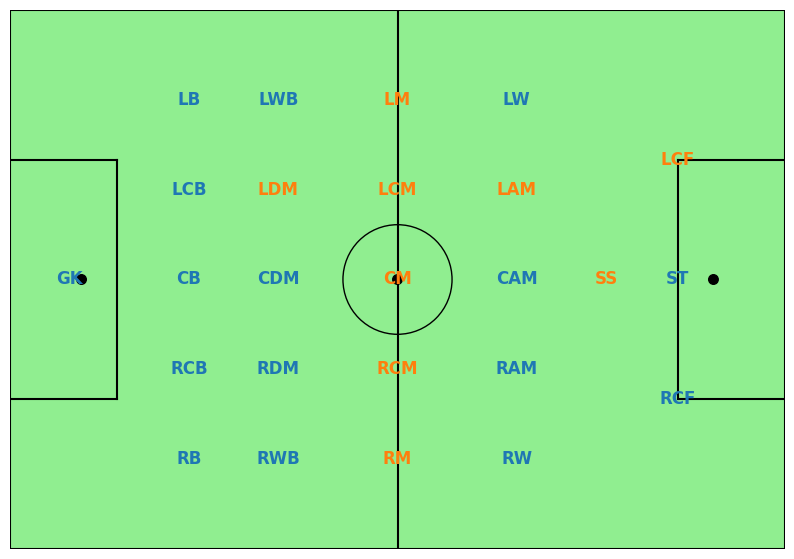

In [8]:
k = 2  
clusters, cluster_colors = cluster_positions_cosine(k)

positions = {
    'GK': (10, 45), 'RB': (30, 15), 'RCB': (30, 30), 'CB': (30, 45), 'LCB': (30, 60), 'LB': (30, 75),
    'RWB': (45, 15), 'RDM': (45, 30), 'CDM': (45, 45), 'LDM': (45, 60), 'LWB': (45, 75),
    'RM': (65, 15), 'RCM': (65, 30), 'CM': (65, 45), 'LCM': (65, 60), 'LM': (65, 75),
    'RW': (85, 15), 'RAM': (85, 30), 'CAM': (85, 45), 'LAM': (85, 60), 'LW': (85, 75),
    'RCF': (112, 25), 'ST': (112, 45), 'LCF': (112, 65), 'SS': (100, 45)
}

plot_positions(positions, clusters, cluster_colors)


Cluster 0 (sorted by proximity to center): ['RB', 'GK', 'LW', 'CAM', 'RCB', 'CDM', 'LB', 'ST', 'LWB', 'LCB', 'RAM']
Cluster 1 (sorted by proximity to center): ['RDM', 'RCF', 'RWB', 'LCF', 'CB', 'RW', 'SS']
Cluster 2 (sorted by proximity to center): ['RCM', 'LM', 'LCM', 'RM', 'LDM', 'CM', 'LAM']


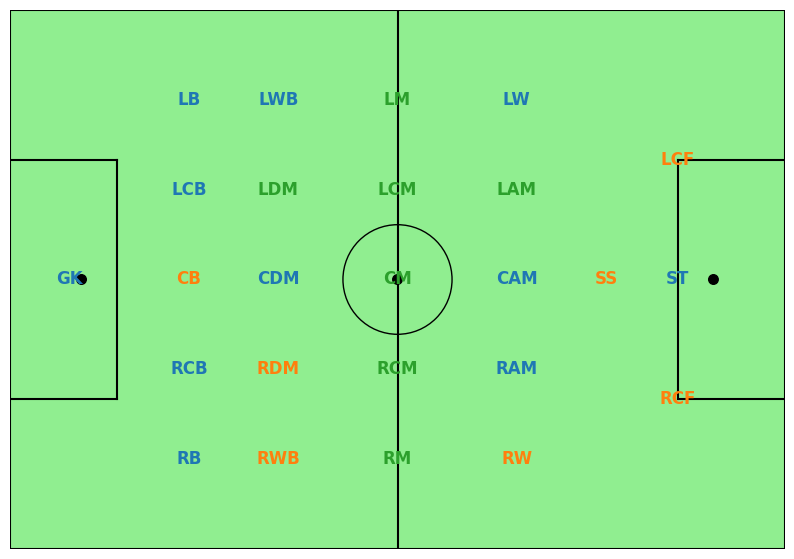

In [9]:
k = 3
clusters, cluster_colors = cluster_positions_cosine(k)

positions = {
    'GK': (10, 45), 'RB': (30, 15), 'RCB': (30, 30), 'CB': (30, 45), 'LCB': (30, 60), 'LB': (30, 75),
    'RWB': (45, 15), 'RDM': (45, 30), 'CDM': (45, 45), 'LDM': (45, 60), 'LWB': (45, 75),
    'RM': (65, 15), 'RCM': (65, 30), 'CM': (65, 45), 'LCM': (65, 60), 'LM': (65, 75),
    'RW': (85, 15), 'RAM': (85, 30), 'CAM': (85, 45), 'LAM': (85, 60), 'LW': (85, 75),
    'RCF': (112, 25), 'ST': (112, 45), 'LCF': (112, 65), 'SS': (100, 45)
}

plot_positions(positions, clusters, cluster_colors)


##### 2.2 Player-Position fit

More than rigid zone on the pitch, RisingBALLER learns positional embeddings that captures contextual attributes of players during matches and learn features to represent which positions a player is really fit for.

In [11]:
"""
Here, we will filter the players to retain only those who have played at least 15 matches in the dataset. 
This results in a total of 1,800 players out of the 5,000+ in the dataset.
"""

df_played = df_input[df_input['is_aligned'] == 1]
player_counts = df_played['player_name'].value_counts()
players_at_least_15 = player_counts[player_counts >= 15].index.tolist()

print(len(players_at_least_15))

1800


In [76]:
""" 
For a list of players of interest, we will plot the distribution of their positions as provided by StatsBomb 
alongside their actual best-fitted positions learned by the model.
"""

X = players_embeddings
players_positions_fit_dict = {}

positions_list = ['GK', 'RB', 'RCB', 'CB', 'LCB', 'LB', 'RWB', 'LWB', 'RDM', 'CDM', 'LDM',
                      'RM', 'RCM', 'CM', 'LCM', 'LM', 'RW', 'RAM', 'CAM', 'LAM', 'LW',
                      'RCF', 'ST', 'LCF', 'SS']

N= 3
def player_pos_similarity(player_emb, pos_emb):

  return np.dot(player_emb, pos_emb)/(np.linalg.norm(player_emb)*np.linalg.norm(pos_emb))+1 # +1 to have a positive score between 0 and 2

players_positions_fit_dict = {}
for idx_player, player in tqdm(enumerate(PLAYER_NAME2LABEL)):
  players_positions_fit_dict[player] = {}
  if player in players_at_least_15:
    positions_sim = []
    
    for idx_pos, position in enumerate(positions_list):
      positions_sim.append(player_pos_similarity(positions_embeddings[idx_pos], X[idx_player]))
    
  positions_sim = np.array(positions_sim)
  top_n_indices = np.argsort(positions_sim)[-N:]

  top_n_sim = [positions_sim[top_n_indices[N-i-1]] for i in range(N)]
  top_n_positions = [positions_list[top_n_indices[N-i-1]] for i in range(N)]

  players_positions_fit_dict[player]['top3_pos'] = top_n_positions
  players_positions_fit_dict[player]['top3_scores'] = top_n_sim/np.sum(top_n_sim)


0it [00:00, ?it/s]

5106it [00:00, 5719.32it/s]


In [78]:
def plot_combined_pos_distrib(player_name):
    pos = players_positions_fit_dict[player_name]['top3_pos']
    scores = players_positions_fit_dict[player_name]['top3_scores']
    data_learned = {
        'position_name': pos,
        'count': scores
    }
    df_learned = pd.DataFrame(data_learned)

    df_player_pos = df_input[df_input.player_name == player_name].position_name.value_counts()
    data_real = {
        'position_name': df_player_pos.index,
        'count': list(df_player_pos)
    }
    df_real = pd.DataFrame(data_real)

    df_real_filtered = df_real[df_real['position_name'] != 'position_pad']

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    sns.barplot(x='count', y='position_name', data=df_learned, palette="viridis", ax=axes[0], hue='position_name', legend=False)
    axes[0].set_title(f"{player_name} - Learned Positions")
    axes[0].set_xlabel("Top 3 Learned Position Distrib")
    axes[0].set_ylabel("Position")

    sns.barplot(x='count', y='position_name', data=df_real_filtered, palette="viridis", ax=axes[1], hue='position_name', legend=False)
    axes[1].set_title(f"{player_name} - Prior Reported Positions")
    axes[1].set_xlabel("Number of Matches")
    axes[1].set_ylabel("Position")

    plt.tight_layout()

    plt.show()


They call Dimitri Payet a left winger, but we all know the kind of playmaker he truly is. RisingBALLER shows he’s better suited for a Central Attacking Midfield position!

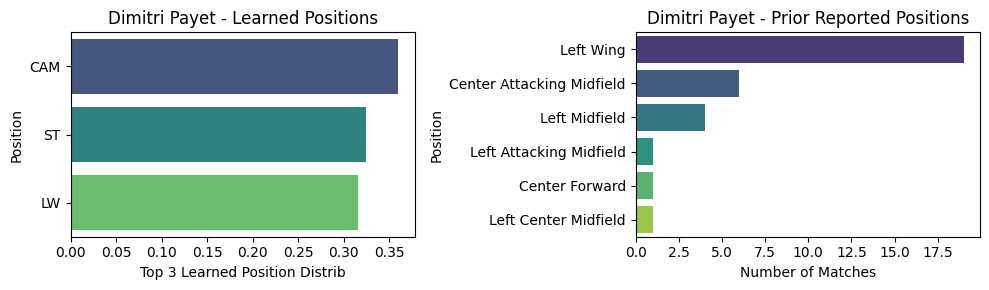

In [79]:
plot_combined_pos_distrib('Dimitri Payet')

What about João Cancelo? Contrary to what's often reported, we all know from watching him that he's not just a pure defender. RisingBALLER captures this subtle aspect of his versatile playing style as well.

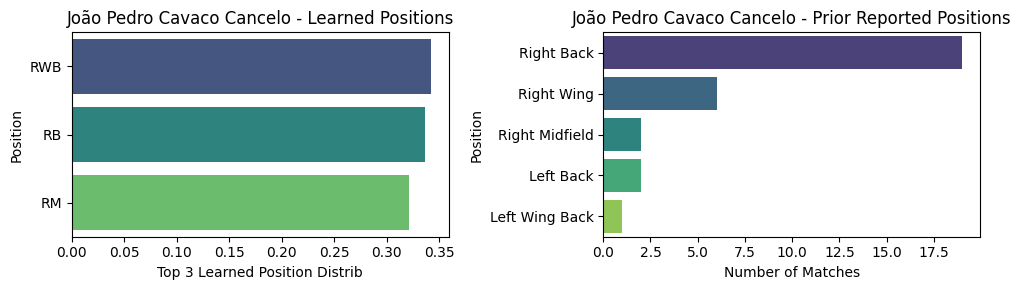

In [37]:
plot_combined_pos_distrib('João Pedro Cavaco Cancelo')

And then there’s Lionel Messi, who is definitely not just a right winger, as often reported in match lineups. He is the ultimate playmaker, and RisingBALLER indicates he’s better suited for a Central Attacking Midfield position.

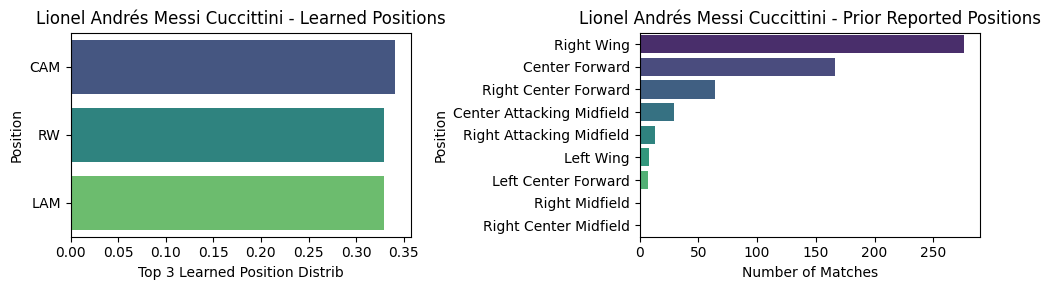

In [43]:
plot_combined_pos_distrib('Lionel Andrés Messi Cuccittini')

This is even more interesting: Karim Benzema is definitely not a pure striker. Even though we all know this, he’s still listed as a center forward on match sheets. However, RisingBALLER has the ability to learn features that show he plays more like an attacking midfielder.

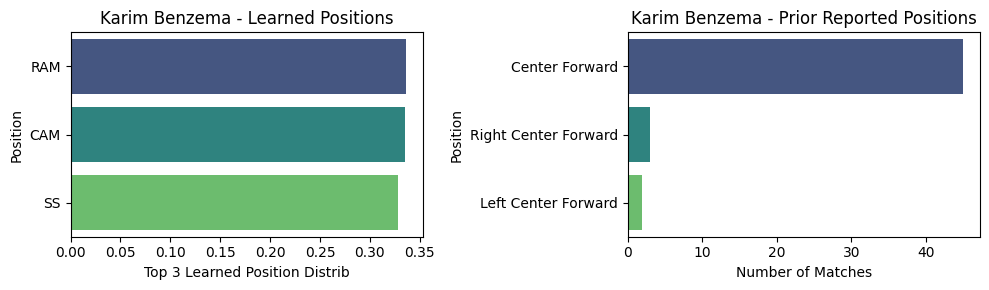

In [48]:
plot_combined_pos_distrib('Karim Benzema')

Remember those moments at the end of matches when Piqué becomes Barcelona's second striker? The model has the ability to learn features that represent this aspect of Piqué's gameplay as well.

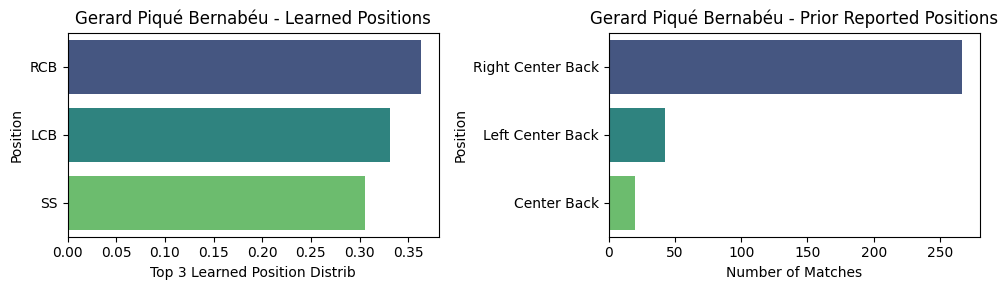

In [57]:
plot_combined_pos_distrib('Gerard Piqué Bernabéu')

Do you remember David Luiz and how he plays as a semi-defender/semi-midfielder? Is he really a center back, as listed in many match sheets? Let’s see what RisingBALLER has learned.

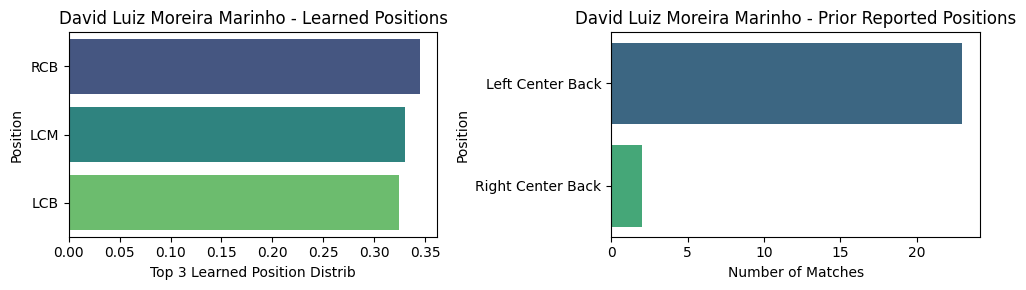

In [59]:
plot_combined_pos_distrib('David Luiz Moreira Marinho')

##### 2.3 Team cohesion estimation

- Utilize a checkpoint trained with team affiliation embeddings.
- For a list of clubs of interest, plot a bar chart of players’ fit scores (average similarity with all teammates) for each team.

*(This will be released soon with the Next Match Statistics Prediction feature.)*

##### 2.4 Players Retrieval

- test RisB-Profiler (https://risb-profiler.streamlit.app/)
- the app repo: (https://github.com/akedjouadj/RisB-Profiler)